### Torus Geometry
- **Triangular unit cell**: Primitive vectors |G₁|=|G₂| with 120 degree in between
- **Landau level**: n = 0 (lowest Landau level)
- **Brillouin zone area**: 2π/l² = √0.75 × G²
- **Magnetic length**: l = √(ℏ/eB) sets the length scale

### Bilayer Parameters
- **Nc = 2**: Number of layers (components)
- **Inter-layer distance**: d/l
- **Tunneling amplitude**: t/W0 (if t=0, layer becomes conserved)
- **Displacement field**: ΔE/W0, energy difference between layers

### Interaction Details
- **Layer conservation**: Interactions preserve layer index of each particle
- **Layer symmetric**: Interactions unchanged if swap the two layer indices
- **Gate Screening**: D/l
- **Different-layer interaction**: Includes e^{-ql*d/l} attenuation factor
- **Form factor**: See arXiv.2509.07784 Eq.(A28) 

In [1]:
# Define k-mesh for bilayer system (4×3 mesh, Nk=12) in triangular lattice
k_list = [0 1 2 3 0 1 2 3 0 1 2 3;
          0 0 0 0 1 1 1 1 2 2 2 2]
Nk = 12
Gk = (4, 3)  # Grid dimensions

# Total number of electrons (3 electrons across both layers)
Ne = 6

# Number of layers (components) for bilayer system
Nc_hopping = 2

2

In [ ]:
# Import the momentum-conserved exact diagonalization package
using MomentumED
include("Landau level triangular.jl")
using .LLT

In [71]:
# Physical parameters
LLT.W0 = 1.0                   # Interaction strength
LLT.D_l = 10.0                  # Screening length D/l
LLT.d_l = -0.2                  # Inter-layer distance d/l
t = 0.0 * LLT.W0               # Inter-layer tunneling strength
ΔE = 0 * LLT.W0                # Energy difference between the two layers

# Set up one-body Hamiltonian matrix for inter-layer tunneling
# H_onebody[c1, c2, cc, k] : hopping from component c2 to c1 at momentum k
# For bilayer system: Nc_hopping=2, Nc_conserve=1, Nk=6
H_onebody_bilayer = zeros(ComplexF64, Nc_hopping, Nc_hopping, 1, Nk)

# Add tunneling terms: t = 0.5 * W0 between different layers
# Tunneling conserves momentum (diagonal in k-space)
for k_idx in 1:Nk
    # Hopping from layer 2 to layer 1
    H_onebody_bilayer[1, 2, 1, k_idx] = t
    # Hopping from layer 1 to layer 2  
    H_onebody_bilayer[2, 1, 1, k_idx] = t
    H_onebody_bilayer[1, 1, 1, k_idx] = 0.5ΔE
    H_onebody_bilayer[2, 2, 1, k_idx] = -0.5ΔE
end


# Create parameter structure for bilayer system
# Note: H_onebody matrix handles tunneling, V_int handles interactions
para_bilayer = EDPara(
    k_list = k_list, 
    Gk = Gk, 
    Nc_hopping = Nc_hopping,
    Nc_conserve = 1,
    H_onebody = H_onebody_bilayer,
    V_int = LLT.V_int_bilayer,
    FF_inf_angle = LLT.Landau_ff_inf,
);

In [72]:
# Create momentum blocks for bilayer system
blocks, block_k1, block_k2, k0number = 
    ED_momentum_block_division(para_bilayer, ED_mbslist(para_bilayer, (Ne,)));
length.(blocks)

12-element Vector{Int64}:
 11202
 11196
 11196
 11240
 11232
 11232
 11202
 11196
 11196
 11240
 11232
 11232

In [73]:
# Generate scattering lists for efficient Hamiltonian construction
scat_list1 = ED_sortedScatteringList_onebody(para_bilayer);
scat_list2 = ED_sortedScatteringList_twobody(para_bilayer);

In [74]:
Neigen = 10
energies = Vector{Vector{Float64}}(undef, length(blocks))
vectors = Vector{Vector{Vector{ComplexF64}}}(undef, length(blocks))
for i in eachindex(blocks)
    println("Processing block #$i with size $(length(blocks[i])), momentum $(block_k1[i]), $(block_k2[i])")
    energies[i], vectors[i] = EDsolve(blocks[i], scat_list2, scat_list1; 
        N = Neigen, showtime=true,
    )
end

Processing block #1 with size 11202, momentum 0, 0
  4.049089 seconds (110.20 M allocations: 2.391 GiB, 10.59% gc time)
  1.633370 seconds (16.15 k allocations: 344.569 MiB, 1.04% gc time)
Processing block #2 with size 11196, momentum 0, 1
  3.919193 seconds (110.14 M allocations: 2.389 GiB, 10.87% gc time)
  2.128697 seconds (20.15 k allocations: 436.330 MiB, 1.90% gc time)
Processing block #3 with size 11196, momentum 0, 2
  4.048695 seconds (110.14 M allocations: 2.389 GiB, 14.32% gc time)
  2.008620 seconds (20.15 k allocations: 436.329 MiB, 1.19% gc time)
Processing block #4 with size 11240, momentum 1, 0
  3.879525 seconds (110.61 M allocations: 2.400 GiB, 10.91% gc time)
  1.514252 seconds (13.42 k allocations: 288.081 MiB, 10.70% gc time)
Processing block #5 with size 11232, momentum 1, 1
  3.882262 seconds (110.52 M allocations: 2.398 GiB, 10.86% gc time)
  1.381323 seconds (13.66 k allocations: 293.047 MiB, 1.00% gc time)
Processing block #6 with size 11232, momentum 1, 2
  3

In [75]:
# The package for plotting is not included in this package. Use the following to add it:
# using Pkg; Pkg.add("CairoMakie")

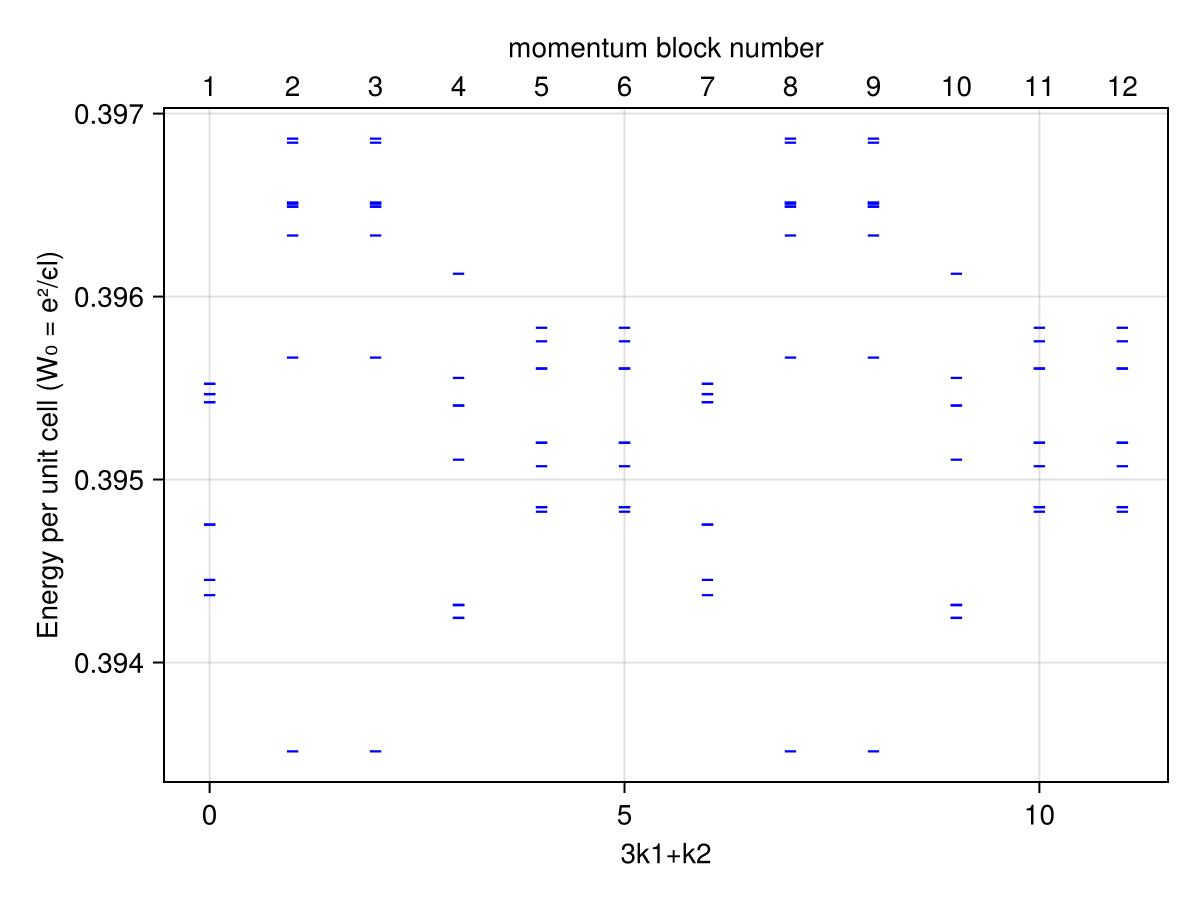

In [76]:
using CairoMakie
CairoMakie.activate!()

# Plot the energy spectrum
fig = Figure();
ax = Axis(fig[1, 1];
    xlabel = "$(Gk[2])k1+k2",
    ylabel = "Energy per unit cell (W₀ = e²/ϵl)"
)
ax_top = Axis(fig[1, 1];
    xlabel = "momentum block number",
    xaxisposition = :top
)
top_ticks = ([], [])
hidespines!(ax_top)
hidexdecorations!(ax_top; label = false, ticklabels = false)
hideydecorations!(ax_top)
linkxaxes!(ax, ax_top)

# Plot energy levels for each momentum block
for i in 1:length(blocks)
    x = Gk[2] * block_k1[i] + block_k2[i]
    push!(top_ticks[1], x)
    push!(top_ticks[2], string(i))
    for e in energies[i]
        scatter!(ax, x, e/Nk/LLT.W0, color = :blue, marker=:hline)
    end
end
ax_top.xticks = top_ticks
fig

In [79]:
# check energies explicitly to see degeneracy.

bn = 2 # the block number to inspect
println("total momentum: ", block_k1[bn], "  ", block_k2[bn])
energies[bn]/Nk/LLT.W0

total momentum: 0  1


10-element Vector{Float64}:
 0.393514525868812
 0.3956666547295619
 0.3963338768872255
 0.39649163275308713
 0.3964916327530883
 0.39650874249503715
 0.39650874249503737
 0.3965145839210827
 0.3968411805167115
 0.39686329377533774

Compute and plot one-body reduced density matrix

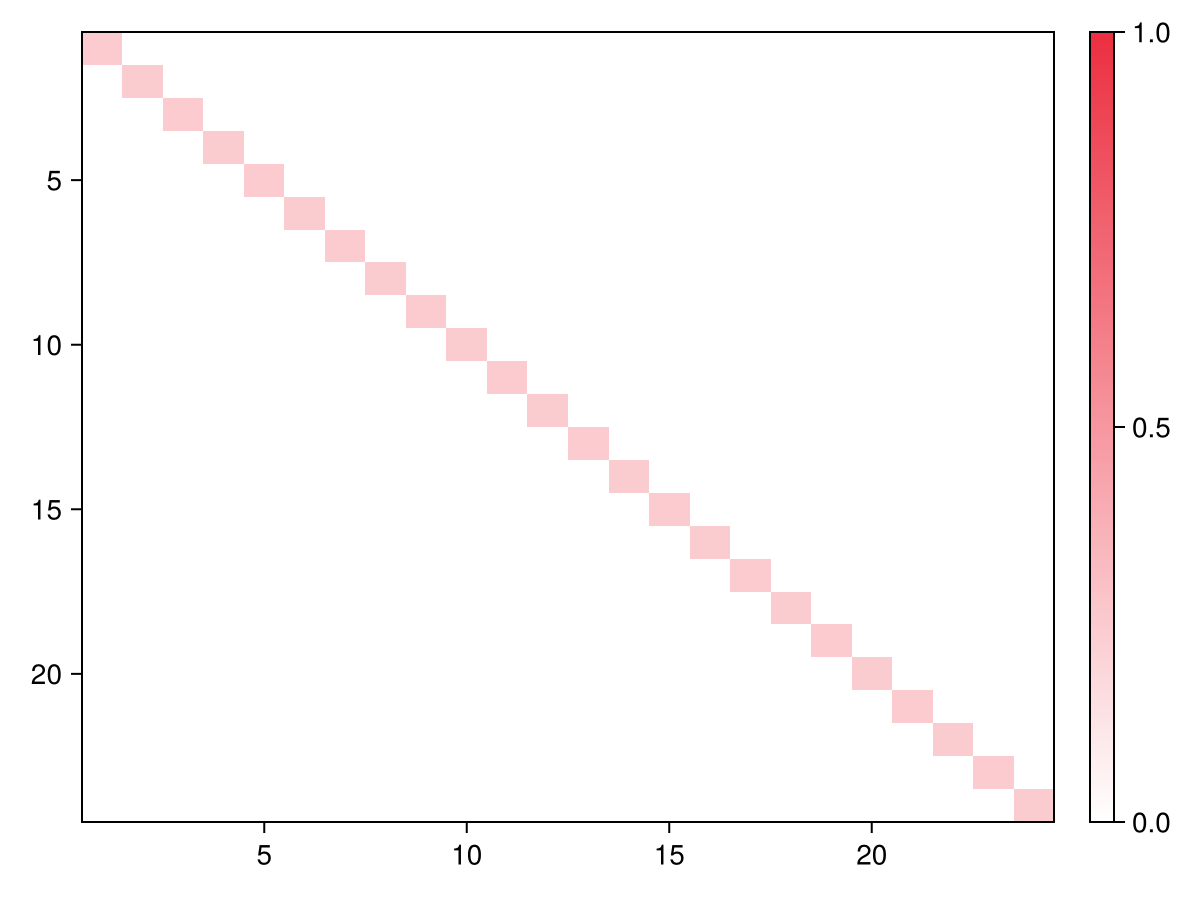

In [80]:
# plot the reduced density matrix of the ground eigenstate in the first block
rdm = ED_onebody_rdm(blocks[bn], vectors[bn][1])

fig = Figure();
ax = Axis(fig[1, 1]; yreversed = true)
hm = heatmap!(ax, abs.(rdm); colorrange = (0,1), 
    colormap = range(Makie.Colors.colorant"white", stop=Makie.Colors.colorant"#ec2f41", length=15)
)
Colorbar(fig[1, 2], hm)
fig

Compute the many-body connection and the Wilson loop for many-body Chern number.

In [81]:
# twist angle path for the Wilson loop integral
N_shift = 5  # number of shifts along each edge
path = Tuple{Float64, Float64}[(0.0, 0.0)]
for i in 1:N_shift
    push!(path, (i/N_shift, 0.0))
end
for i in 1:N_shift
    push!(path, (1.0, i/N_shift))
end
for i in 1:N_shift
    push!(path, ((N_shift - i)/N_shift, 1.0))
end
for i in 1:N_shift
    push!(path, (0.0, (N_shift - i)/N_shift))
end
path

21-element Vector{Tuple{Float64, Float64}}:
 (0.0, 0.0)
 (0.2, 0.0)
 (0.4, 0.0)
 (0.6, 0.0)
 (0.8, 0.0)
 (1.0, 0.0)
 (1.0, 0.2)
 (1.0, 0.4)
 (1.0, 0.6)
 (1.0, 0.8)
 ⋮
 (0.6, 1.0)
 (0.4, 1.0)
 (0.2, 1.0)
 (0.0, 1.0)
 (0.0, 0.8)
 (0.0, 0.6)
 (0.0, 0.4)
 (0.0, 0.2)
 (0.0, 0.0)

In [82]:
bn = 3                     # block number
nstates = 1                # number of degenerating states

psi_before = reduce(hcat, vectors[bn][1:nstates])
ED_connection_gaugefixing!(psi_before, [10024])  # fix global phase
psi_after = similar(psi_before)

WilsonLoopIntegral= Vector{Float64}(undef, 4N_shift)
for i in eachindex(WilsonLoopIntegral)

    println("path point #$i \t $(path[i+1])")

    scat_list = ED_sortedScatteringList_twobody(para_bilayer; kshift = path[i+1]);
    vecs = EDsolve(blocks[bn], scat_list; N = 6,
        showtime = false,
    )[2][1:nstates]
    psi_after .= reduce(hcat, vecs)
    ED_connection_gaugefixing!(psi_after, [10024])  # fix global phase

    WilsonLoopIntegral[i] = ED_connection_step(blocks[bn], 
        psi_after, psi_before, path[i+1], path[i], para_bilayer;
        wavefunction_tol = 1e-8, print_amp = true,
        amp_warn_tol = 0.7, amp_warn = true
    )

    psi_before .= psi_after
end
ManyBodyChernNumber = sum(WilsonLoopIntegral) / (2π)


path point #1 	 (0.2, 0.0)
Inner product: amp = 1.0000000000000029, phase = 0.4188790204785792
path point #2 	 (0.4, 0.0)
Inner product: amp = 1.000000000000001, phase = 0.4188790204786799
path point #3 	 (0.6, 0.0)
Inner product: amp = 0.9999999999999998, phase = 0.4188790204786749
path point #4 	 (0.8, 0.0)
Inner product: amp = 0.9999999999999999, phase = 0.41887902047861136
path point #5 	 (1.0, 0.0)
Inner product: amp = 1.0000000000000018, phase = 0.41887902047865144
path point #6 	 (1.0, 0.2)
Inner product: amp = 0.9999999999999968, phase = -0.9424777960769238
path point #7 	 (1.0, 0.4)
Inner product: amp = 0.9999999999999964, phase = -0.9424777960769588
path point #8 	 (1.0, 0.6)
Inner product: amp = 0.9999999999999976, phase = -0.9424777960769161
path point #9 	 (1.0, 0.8)
Inner product: amp = 0.9999999999999932, phase = -0.9424777960769655
path point #10 	 (1.0, 1.0)
Inner product: amp = 1.0000000000000007, phase = -0.9424777960769359
path point #11 	 (0.8, 1.0)
Inner product: 

-0.4999999999999941

#### In the specific case when interlayer tunneling t=0, particle numbers of the two layers are conserved.

In [83]:
# Number of layers (components) for bilayer system
Nc_conserve = 2

# Define k-mesh for bilayer system (4×3 mesh, Nk=12) in triangular lattice
k_list = [0 1 2 3 0 1 2 3 0 1 2 3;
          0 0 0 0 1 1 1 1 2 2 2 2]
Nk = 12
Gk = (4, 3)  # Grid dimensions


# number of electrons in each layer
Ne1 = 3
Ne2 = 3

3

In [84]:
# Import the momentum-conserved exact diagonalization package
using MomentumED
include("Landau level triangular.jl")
using .LLT

In [85]:
# Physical parameters
LLT.W0 = 1.0                   # Interaction strength
LLT.D_l = 10.0                  # Screening length D/l
LLT.d_l = -0.2                  # Inter-layer distance d/l
t = 0.0 * LLT.W0               # Inter-layer tunneling strength
ΔE = 0 * LLT.W0                # Energy difference between the two layers


# Set up one-body Hamiltonian matrix for inter-layer tunneling
# H_onebody[c1, c2, cc, k] : no hopping from component c2 to c1
# For bilayer system: Nc_hopping=1, Nc_conserve=2, Nk=6
H_onebody_bilayer_no_tunneling = zeros(ComplexF64, 1, 1, Nc_conserve, Nk)
# Add energy difference terms: ΔE = 0.5 * W0 between different layers
# No tunneling
for k_idx in 1:Nk
    H_onebody_bilayer_no_tunneling[1, 1, 1, k_idx] = 0.5ΔE
    H_onebody_bilayer_no_tunneling[1, 1, 2, k_idx] = -0.5ΔE
end

# Create parameter structure for bilayer system
# Note: H_onebody matrix handles tunneling, V_int handles interactions
para_conserve = EDPara(
    k_list = k_list, 
    Gk = Gk, 
    Nc_hopping = 1,
    Nc_conserve = Nc_conserve,
    H_onebody = H_onebody_bilayer_no_tunneling,
    V_int = LLT.V_int_bilayer,
    FF_inf_angle = LLT.Landau_ff_inf, 
);

In [86]:
# Create momentum blocks for bilayer system
blocks, block_k1, block_k2, k0number = 
    ED_momentum_block_division(para_conserve, ED_mbslist(para_conserve, (Ne1,Ne2)));
length.(blocks)

12-element Vector{Int64}:
 4036
 4032
 4032
 4036
 4032
 4032
 4036
 4032
 4032
 4036
 4032
 4032

In [87]:
# Generate scattering lists for efficient Hamiltonian construction
scat_list1_conserve = ED_sortedScatteringList_onebody(para_conserve);
scat_list2_conserve = ED_sortedScatteringList_twobody(para_conserve);

In [88]:
Neigen = 10  # Number of eigenvalues to compute per block
energies = Vector{Vector{Float64}}(undef, length(blocks))
vectors = Vector{Vector{Vector{ComplexF64}}}(undef, length(blocks))
for i in eachindex(blocks)
    println("Processing block #$i with size $(length(blocks[i])), momentum $(block_k1[i]), $(block_k2[i])")
    energies[i], vectors[i] = EDsolve(blocks[i], scat_list2_conserve, scat_list1_conserve;
        N = Neigen, showtime=true
    )
end

Processing block #1 with size 4036, momentum 0, 0
  2.854906 seconds (40.35 M allocations: 904.388 MiB, 11.08% gc time)
  0.409093 seconds (8.95 k allocations: 68.802 MiB, 2.25% gc time)
Processing block #2 with size 4032, momentum 0, 1
  2.960991 seconds (40.30 M allocations: 903.219 MiB, 16.04% gc time)
  0.455035 seconds (9.20 k allocations: 70.610 MiB)
Processing block #3 with size 4032, momentum 0, 2
  3.032183 seconds (40.30 M allocations: 903.219 MiB, 10.95% gc time)
  0.571473 seconds (9.50 k allocations: 72.612 MiB, 2.67% gc time)
Processing block #4 with size 4036, momentum 1, 0
  2.935212 seconds (40.35 M allocations: 904.390 MiB, 16.68% gc time)
  0.511525 seconds (11.13 k allocations: 85.674 MiB, 2.12% gc time)
Processing block #5 with size 4032, momentum 1, 1
  2.549459 seconds (40.30 M allocations: 903.219 MiB, 10.46% gc time)
  0.398944 seconds (8.49 k allocations: 64.993 MiB, 2.50% gc time)
Processing block #6 with size 4032, momentum 1, 2
  2.975723 seconds (40.30 M a

In [89]:
# The package for plotting is not included in this package. Use the following to add it:
# using Pkg; Pkg.add("CairoMakie")

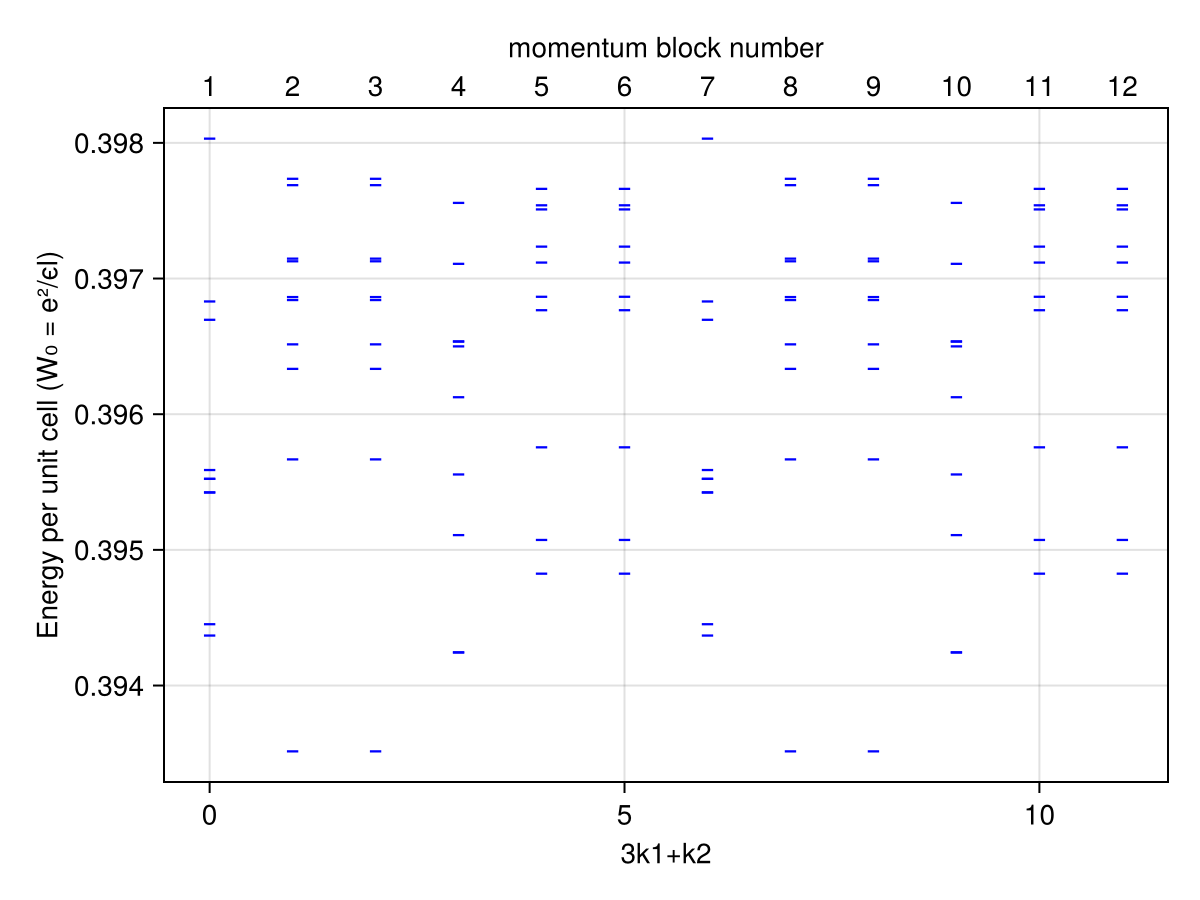

In [90]:
using CairoMakie
CairoMakie.activate!()

# Plot the energy spectrum
fig = Figure();
ax = Axis(fig[1, 1];
    xlabel = "$(Gk[2])k1+k2",
    ylabel = "Energy per unit cell (W₀ = e²/ϵl)"
)
ax_top = Axis(fig[1, 1];
    xlabel = "momentum block number",
    xaxisposition = :top
)
top_ticks = ([], [])
hidespines!(ax_top)
hidexdecorations!(ax_top; label = false, ticklabels = false)
hideydecorations!(ax_top)
linkxaxes!(ax, ax_top)

# Plot energy levels for each momentum block
for i in 1:length(blocks)
    x = Gk[2] * block_k1[i] + block_k2[i]
    push!(top_ticks[1], x)
    push!(top_ticks[2], string(i))
    for e in energies[i]
        scatter!(ax, x, e/Nk/LLT.W0, color = :blue, marker=:hline)
    end
end
ax_top.xticks = top_ticks
fig

In [92]:
# check energies explicitly to see degeneracy.

bn = 1 # the block number to inspect
println("total momentum: ", block_k1[bn], "  ", block_k2[bn])
energies[bn]/Nk/LLT.W0

total momentum: 0  0


10-element Vector{Float64}:
 0.3943682135976468
 0.39445172208385554
 0.3954230684563775
 0.39542306845637804
 0.3955231305756546
 0.395523130575655
 0.39558826240032324
 0.3966956027562875
 0.39683073260959073
 0.39803094879015255